In [3]:
import pandas as pd
import pingouin as pg
import numpy as np
import copy

In [4]:
# read in data
biometric_df = pd.read_excel("../../data/combined_sample_data.xlsx",
    sheet_name="BiometricsAveragedMSData")

In [5]:
# only for Subject 1
extra_biometrics = biometric_df.columns[13:15]
extra_biometrics

Index(['Sleep (hrs)', 'Active Calories'], dtype='object')

In [6]:
# metabolite list
metabolites = biometric_df.columns[18:]

In [7]:
metabolites

Index(['2-Aminoadipic acid 3 TMS', '2-Aminobutyric acid 2 TMS',
       '2-Deoxypentonic acid ', '2-Hydroxy-2-methylbutyric acid 2 TMS',
       '2-Hydroxyglutaric acid 3 TMS',
       '2-Hydroxyglutaric acid-1-ethyl ester 2 TMS',
       '2,3-Dihydroxybutanoic acid 3 TMS',
       '3-(3-Hydroxyphenyl)propanoic acid 2 TMS', '3-Deoxytetronic acid 3 TMS',
       '3-Hydroxybutyric acid 2 TMS',
       ...
       'unknown RT 9.99241', 'Urea 2 TMS', 'Uric acid 4 TMS', 'Valine 2 TMS',
       'Vanillactic acid 2 TMS', 'Vanillylmandelic acid 3 TMS',
       'Xanthine 3 TMS', 'Xanthopterin 3 TMS', 'Xanthosine 5 TMS',
       'Xanthurenic acid 3 TMS'],
      dtype='object', length=603)

In [8]:
# function to generate a dataframe with model correlation results
def return_corr_stats_df(dataframe, metabolite_list, biometric_list, log=True, subject="Single"):

    corr_dict = {}
    p_val_dict = {}
    # populate dictionary with dictionary for each metabolite
    for metabolite in metabolite_list:
        corr_dict[metabolite] = {}
        p_val_dict[metabolite] = {}

    # calculate correlation coef
    for metabolite in metabolites:
        for biometric in biometric_list:
            if log:
                data1, data2 = dataframe[biometric], np.log2(dataframe[metabolite])
            else:
                data1, data2 = dataframe[biometric], dataframe[metabolite]
                
            if subject=="Both":
                rm_data = pd.DataFrame({'x':data1, 'y':data2, 'Subject':dataframe['Subject']})
                # output is different in the version of pingouin (compared to docs)
                r, p, dof = pg.rm_corr(data=rm_data, x='x',y='y', subject='Subject')
                corr_data = {'r':r, 'p-val':p, 'dof':dof}
            else:
                corr_data  = pg.corr(data1, data2, method='skipped').iloc[0].to_dict()
            corr_dict[metabolite][biometric] = corr_data

    corr_output_dataframe = pd.DataFrame(corr_dict).T

    return corr_output_dataframe

In [9]:
# grab data subset for subject 1
subject1_biometric_df = biometric_df[biometric_df['Subject'] == "Subject1"]

# get corr data
subject1_corr_df = return_corr_stats_df(subject1_biometric_df, metabolites, extra_biometrics)

In [10]:
subject1_corr_df.head()

,Active Calories,Sleep (hrs)
2-Aminoadipic acid 3 TMS,"{'n': 8, 'outliers': 1, 'r': 0.5, 'CI95%': [-0...","{'n': 8, 'outliers': 1, 'r': -0.143, 'CI95%': ..."
2-Aminobutyric acid 2 TMS,"{'n': 8, 'outliers': 0, 'r': 0.024, 'CI95%': [...","{'n': 8, 'outliers': 1, 'r': 0.643, 'CI95%': [..."
2-Deoxypentonic acid,"{'n': 8, 'outliers': 0, 'r': 0.571, 'CI95%': [...","{'n': 8, 'outliers': 1, 'r': -0.357, 'CI95%': ..."
2-Hydroxy-2-methylbutyric acid 2 TMS,"{'n': 8, 'outliers': 1, 'r': 0.964, 'CI95%': [...","{'n': 8, 'outliers': 1, 'r': 0.214, 'CI95%': [..."
2-Hydroxyglutaric acid 3 TMS,"{'n': 8, 'outliers': 0, 'r': 0.286, 'CI95%': [...","{'n': 8, 'outliers': 1, 'r': 0.179, 'CI95%': [..."


In [11]:
subject1_corr_df.iloc[0]['Active Calories']

{'n': 8,
 'outliers': 1,
 'r': 0.5,
 'CI95%': array([-0.32,  0.89]),
 'r2': 0.25,
 'adj_r2': -0.05,
 'p-val': 0.25316999510032273,
 'power': 0.255}

In [12]:
# function to extract a data frame for any key in pingouin output dictionary
def return_stat_df(corr_df, stat='r'):
    
    stat_df = copy.deepcopy(corr_df)
    
    for metabolite,row in corr_df.iterrows():
        for column in corr_df.columns:
            stat_df.loc[metabolite][column] = corr_df.loc[metabolite][column][stat]
    
    stat_df = stat_df.astype("float64")
    
    return stat_df

return_stat_df(subject1_corr_df).head()

,Active Calories,Sleep (hrs)
2-Aminoadipic acid 3 TMS,0.500,-0.143
2-Aminobutyric acid 2 TMS,0.024,0.643
2-Deoxypentonic acid,0.571,-0.357
2-Hydroxy-2-methylbutyric acid 2 TMS,0.964,0.214
2-Hydroxyglutaric acid 3 TMS,0.286,0.179


In [13]:
subject1_p_val_df = return_stat_df(subject1_corr_df, stat='p-val')
subject1_p_val_df.head()

,Active Calories,Sleep (hrs)
2-Aminoadipic acid 3 TMS,0.253170,0.759945
2-Aminobutyric acid 2 TMS,0.955374,0.119392
2-Deoxypentonic acid,0.138960,0.431611
2-Hydroxy-2-methylbutyric acid 2 TMS,0.000454,0.644512
2-Hydroxyglutaric acid 3 TMS,0.492726,0.701658


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff978a64358>,
      dtype=object)

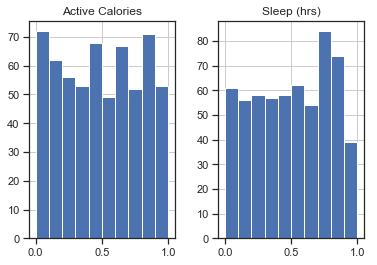

In [14]:
subject1_p_val_df.hist()

In [14]:
# save output to .tsv(s)
subject1_corr_df.to_csv("subject1_corr.tsv", sep="\t")
subject1_p_val_df.to_csv("subject1_p_val.tsv", sep="\t")
return_stat_df(subject1_corr_df, stat='r').to_csv("subject1_coef.tsv", sep="\t")

 ### Apply same approach to rm_corr

In [15]:
# for both subject
shared_biometrics = biometric_df.columns[2:13]
shared_biometrics

Index(['Calories', 'Fat (g)', 'Protein (g)', 'Carbohydrates (g)',
       'Saturated Fat (g)', 'Sugars (g)', 'Fiber (g)', 'Cholesterol (mg)',
       'Sodium (mg)', 'Calories from Alcohol', 'Coffee (fl. oz)'],
      dtype='object')

In [16]:
shared_corr_df = return_corr_stats_df(
    biometric_df, metabolites, shared_biometrics, subject="Both")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff998410710>,
      dtype=object)

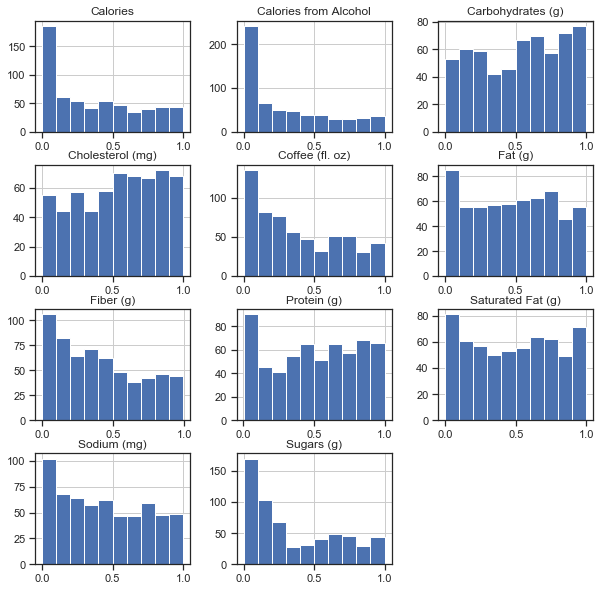

In [17]:
shared_p_val_df = return_stat_df(shared_corr_df, stat='p-val')
shared_p_val_df.hist(figsize=(10,10))

In [18]:
# write out data
shared_corr_df.to_csv("shared_corr.tsv", sep="\t")
shared_p_val_df.to_csv("shared_p_val.tsv", sep="\t")
return_stat_df(shared_corr_df, stat='r').to_csv("shared_coef.tsv", sep="\t")